# Firing rates (KS3)

author: steeve.laquitaine@epfl.ch    
date: 17.01.2023  
last modified: 15.08.2024

* 10 minutes of recordings (as sorting accurac and yield likely change with duration). 10 minutes is a duration common to all recordings.

**Prerequisites**:

- processing: engineer recordings, fits noise and amplification, wires probe, records metadata, preprocesses, writes
- sorting: sorts and records metadata to SortingExtractors

### Setup

Activate `spikeinterf..` python3.9 virtual environment (select interpreter - find envs/ path - add kernel)

In [15]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# SET PROJECT PATH

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config, savefig
from src.nodes.validation import firing_rate as fr
from src.nodes.validation.npx_probe import firing_rate as fr_npx
from src.nodes.validation import firing_rate as fr

# SETUP EXPERIMENTS

# data [done]
cfg_nv, _ = get_config("vivo_marques", "c26").values()
SORTED_PATH_nv = cfg_nv["sorting"]["sorters"]["kilosort3"]["10m"]["output"]

# model biophy. spontaneous [done]
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
SORTED_PATH_ns = cfg_ns["sorting"]["sorters"]["kilosort3"]["10m"]["output"]

# model biophy. evoked (40m)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
SORTED_PATH_ne = cfg_ne["sorting"]["sorters"]["kilosort3"]["10m"]["output"]

# Buccino with best fitted gain for layer 5 [done]
cfg_nb, _ = get_config("buccino_2020", "2020").values()
SORTED_PATH_nb = cfg_nb["sorting"]["sorters"]["kilosort3"]["10m"]["output"]

# PARAMETERS
SINGLE_UNIT = True
layers = ["L1", "L2/3", "L4", "L5", "L6"]

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-08-15 15:32:12,899 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-15 15:32:12,964 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-15 15:32:12,966 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-15 15:32:13,034 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-15 15:32:13,035 - root - utils.py - get_config - INFO - Reading experiment config.


[autoreload of src.nodes.validation.npx_probe.firing_rate failed: Traceback (most recent call last):
  File "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/gpfs/bbp.cscs.ch/home/laquitai/spack_install/environments/spack_python3_9/.spack-env/view/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_t

2024-08-15 15:32:13,113 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-15 15:32:13,115 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-15 15:32:13,156 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Get metadata

In [16]:
# get unit metadata
df_nv = fr.get_sorted_unit_meta(SORTED_PATH_nv)
df_ns = fr.get_sorted_unit_meta(SORTED_PATH_ns)
df_ne = fr.get_sorted_unit_meta(SORTED_PATH_ne)
df_nb = fr.get_synth_unit_meta(SORTED_PATH_nb)

# keep units in cortex
df_nv = df_nv[np.isin(df_nv["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_ns = df_ns[np.isin(df_ns["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_ne = df_ne[np.isin(df_ne["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_ns["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

## Curate/or not

- evidence that false positives are low amplitude sorted spikes
- evidence that L1 silico best matches L1 vivo when selecting higher amplitude spikes
- evidence that other layers best match when selecting all spikes

In [17]:
if SINGLE_UNIT:
    df_nv = df_nv[df_nv["kslabel"] == "good"]
    df_ns = df_ns[df_ns["kslabel"] == "good"]
    df_ne = df_ne[df_ne["kslabel"] == "good"]
    df_nb = df_nb[df_nb["kslabel"] == "good"]

## Sorted units total

In [18]:
print("M: total sorted unit:", df_nv.shape[0])
print("NS: total sorted unit:", df_ns.shape[0])
print("E: total sorted unit:", df_ne.shape[0])
print("S: total sorted unit:", df_nb.shape[0])

M: total sorted unit: 273
NS: total sorted unit: 803
E: total sorted unit: 4602
S: total sorted unit: 515


### Fr. stats

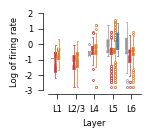

In [19]:
# FIGSIZE = (1.8, 1)
FIGSIZE = (1.2, 1)

fig, ax = plt.subplots(1, figsize=FIGSIZE)
ax, _ = fr_npx.plot_fr_stats_by_layer(ax, df_nv, df_ns, df_ne, df_nb, layers, cl)
ax.set_yticks([-3, -2, -1, 0, 1, 2], [-3, -2, -1, 0, 1, 2])
savefig(
    "figures/0_validation/6_firing_rate/assets/fig4D_logfr_stats_ks3.svg",
)

### Var. stats

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


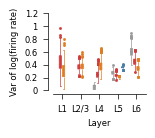

In [20]:
# FIGSIZE = (1.8, 1)
FIGSIZE = (1.2, 1)

fig, ax = plt.subplots(1, figsize=FIGSIZE)
ax, _ = fr_npx.plot_fr_std_stats_by_layer(ax, df_nv, df_ns, df_ne, df_nb, layers, cl)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2], [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
savefig(
    "figures/0_validation/6_firing_rate/assets/fig4E_std_logfr_stats_ks3.svg",
)

#### Plot FR by layer

/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/src/nodes/postpro/spikestats.py:93: RuntimeWarning: invalid value encountered in divide
  y_fit_all = H_all.sum() * y_fit / y_fit.sum()
/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/src/nodes/postpro/spikestats.py:85: RuntimeWarning: invalid value encountered in scalar divide
  mn_all = np.sum(np.log10(data_all) * p_all) / np.sum(p_all)
/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/src/nodes/postpro/spikestats.py:86: RuntimeWarning: invalid value encountered in scalar divide
  sd_all = np.sum(np.abs(np.log10(data_all) * p_all - mn_all)) / np.sum(p_all)
/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/src/nodes/postpro/spikestats.py:89: RuntimeWarning: invalid value encountered in divide
  ax.plot(x_bins[1:], H_all/H_all.sum(), marker="o", ls="none", markersize=markersize, label=label, markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spik

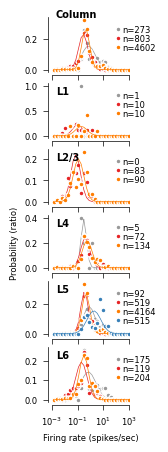

In [21]:
# FIGSIZE = (1.8, 6)
FIGSIZE = (1, 5)

fig, axes = plt.subplots(len(layers) + 1, 1, figsize=FIGSIZE)
fr_npx.plot_fr_by_layer(
    axes, df_nv, df_ns, df_ne, df_nb, layers, log_x_min, log_x_max, nbins, t_dec, cl
)
savefig(
    "figures/0_validation/6_firing_rate/assets/fig4F_npx_fr_ks3.svg",
)